# Boro Player Predictions - Current Market Value

In [1]:
## standard library
import os
import sys
import re
import pickle
import shutil

In [2]:
## data wrangling
import numpy as np
import pandas as pd

pd.set_option("display.latex.repr", True)

In [3]:
## visualisation
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
sns.set()

In [4]:
## machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [5]:
## project src
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../src'))
# sys.path

%load_ext autoreload
%autoreload 2

# import utilities
import players

In [6]:
## global constants
RANDOM_STATE = 4

## 1. Business Understanding

* Determine Busines Objectives
* Situation Assessment
* Determine Data Mining Goal
* Produce Project Plan

The aim of this project is to see if we can use data on players at Middlesbrough Football Club to make preditions about the player's and the team's current and future performance.

We have player data from Transfermarkt, ESPN, WhoScored and Fly Me To The Moon (fanzine).

"Performance" could be measured in many different ways: Results on the pitch, market value, fan popularity, churn, ...

A number of key performance metrics will be investigated in turn, looking at how predictable each is...

1) Current market value

2) Current fan popularity

3) Current performance rating

... and more TBC ...


## 2. Data Understanding

* Collect Initial Data
* Describe Data
* Explore Data
* Verify Data Quality

In [7]:
print("Loading Transfermarkt general information...")

tmk_df = players.clean_data("tmk_cnt")
# tmk_df.info()

Loading Transfermarkt general information...
tmk_cnt_mbr_all_0910.csv
tmk_cnt_mbr_all_1011.csv
tmk_cnt_mbr_all_1112.csv
tmk_cnt_mbr_all_1213.csv
tmk_cnt_mbr_all_1314.csv
tmk_cnt_mbr_all_1415.csv
tmk_cnt_mbr_all_1516.csv
tmk_cnt_mbr_all_1617.csv
tmk_cnt_mbr_all_1718.csv
tmk_cnt_mbr_all_1819.csv
tmk_cnt_mbr_all_1920.csv


In [8]:
print("Random sample of records...")

tmk_df.sample(8, random_state=RANDOM_STATE)

Random sample of records...


,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
240,16.0,Centre Forward,Bartholomew Ogbeche,1984-10-01,178.0,both,2011-10-01,NaT,0.450,11/12,F,26
518,7.0,Central Midfield,Grant Leadbitter,1986-01-07,177.0,right,2012-07-01,2017-06-30,1.500,15/16,M,30
611,13.0,Keeper,Tomás Mejías,1989-01-30,195.0,right,2014-07-05,2018-06-30,0.225,17/18,G,29
28,3.0,Left-Back,Andrew Taylor,1986-08-01,178.0,left,2005-07-01,NaT,1.880,09/10,D,22
274,2.0,Right-Back,Justin Hoyte,1984-11-20,180.0,right,2008-08-01,NaT,1.130,12/13,D,27
48,34.0,Defensive Midfield,Isaiah Osbourne,1987-11-05,188.0,right,2009-11-06,NaT,0.375,09/10,M,21
618,4.0,Centre-Back,Daniel Ayala,1990-11-07,190.0,right,2014-01-24,2020-06-30,1.800,17/18,D,27
198,3.0,Left-Back,Joe Bennett,1990-03-28,177.0,left,2008-07-01,NaT,0.188,11/12,D,21


In [9]:
print("Summary of whole data source...")

tmk_df.describe(include="all")

Summary of whole data source...


,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
count,333.000000,364,364,364,356.000000,324,351,169,330.000000,364,364,364.000000
unique,NaN,19,172,169,NaN,3,126,12,NaN,11,4,NaN
top,NaN,Centre Back,Ben Gibson,1993-01-15 00:00:00,NaN,right,2010-07-01 00:00:00,2020-06-30 00:00:00,NaN,09/10,M,NaN
freq,NaN,53,9,9,NaN,201,31,28,NaN,47,134,NaN
first,NaN,NaN,NaN,1973-08-27 00:00:00,NaN,NaN,2000-07-01 00:00:00,2016-05-31 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2000-08-09 00:00:00,NaN,NaN,2020-01-31 00:00:00,2023-06-30 00:00:00,NaN,NaN,NaN,NaN
mean,18.054054,NaN,NaN,NaN,183.286517,NaN,NaN,NaN,1.696327,NaN,NaN,24.826923
std,11.018471,NaN,NaN,NaN,6.028752,NaN,NaN,NaN,1.776398,NaN,NaN,4.696900
min,1.000000,NaN,NaN,NaN,167.000000,NaN,NaN,NaN,0.038000,NaN,NaN,16.000000
25%,8.000000,NaN,NaN,NaN,179.000000,NaN,NaN,NaN,0.375000,NaN,NaN,21.000000


**ANALYSIS:** So the data is looking broadly in good shape, but there are a few missing values to consider...

In [10]:
# print("% populated...")

pd.DataFrame(100 * tmk_df.count() / tmk_df.shape[0], columns=["% populated"])

,% populated
Shirt number,91.483516
Position,100.000000
Name,100.000000
Date of birth,100.000000
Height,97.802198
Foot,89.010989
Joined,96.428571
Contract expires,46.428571
Market value,90.659341
Season,100.000000


**ANALYSIS:** Only `Joined` has large gaps. Let's look at it in more detail...

In [11]:
print("Players with missing Joined dates...")

tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Joined.notna()].Name.values)
       & tmk_df.Name.isin(tmk_df[tmk_df.Joined.isna()].Name.values)].sort_values(by=["Name", "Season"])[["Name", "Season", "Joined"]].T

Players with missing Joined dates...


,156,220,300,374,454,26,120,194,266,348,416,490,547,616,24,122,282,364,440,512,60,154,218,298,102,182,250,334,406,482,542,92,174,242,322,396,476
Name,Adam Reach,Adam Reach,Adam Reach,Adam Reach,Adam Reach,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Bruno Pilatos,Bruno Pilatos,Bryn Morris,Bryn Morris,Bryn Morris,Bryn Morris,Cameron Park,Cameron Park,Cameron Park,Cameron Park,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Luke Williams,Luke Williams,Luke Williams,Luke Williams,Luke Williams,Luke Williams
Season,10/11,11/12,12/13,13/14,14/15,09/10,10/11,11/12,12/13,13/14,14/15,15/16,16/17,17/18,09/10,10/11,12/13,13/14,14/15,15/16,09/10,10/11,11/12,12/13,10/11,11/12,12/13,13/14,14/15,15/16,16/17,09/10,10/11,11/12,12/13,13/14,14/15
Joined,NaT,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,NaT,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,NaT,2010-07-01 00:00:00,NaT,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00,NaT,NaT,2011-07-01 00:00:00,2011-07-01 00:00:00,NaT,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,NaT,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00


**ANALYSIS:** _Possibly_ we could back fill some missing `Joined` dates but this might have some downstream consequences because the date _might_ exceed the end of that season. We'll leave them as Nulls for now.

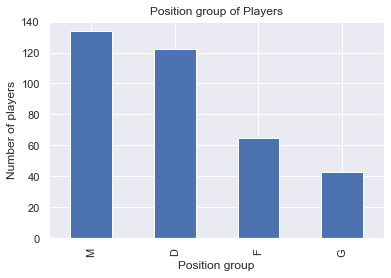

In [12]:
tmk_df["Position group"].value_counts().plot(kind='bar')
plt.title('Position group of Players')
plt.xlabel('Position group')
plt.ylabel('Number of players');

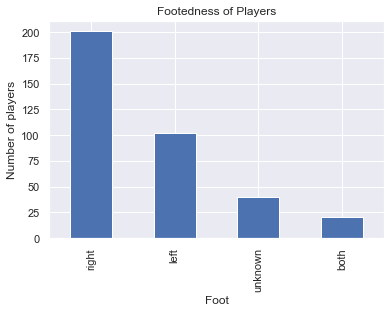

In [13]:
tmk_df.Foot.fillna("unknown").value_counts().plot(kind='bar')
plt.title('Footedness of Players')
plt.xlabel('Foot')
plt.ylabel('Number of players');

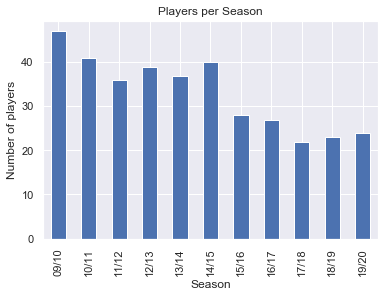

In [14]:
tmk_df.Season.value_counts().sort_index().plot(kind='bar')
plt.title('Players per Season')
plt.xlabel('Season')
plt.ylabel('Number of players');

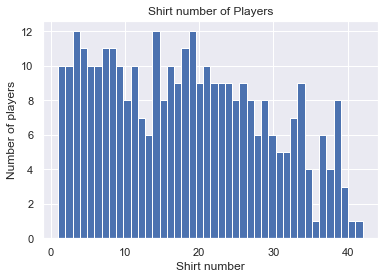

In [15]:
tmk_df["Shirt number"].hist(bins=42)
plt.title('Shirt number of Players')
plt.xlabel('Shirt number')
plt.ylabel('Number of players');

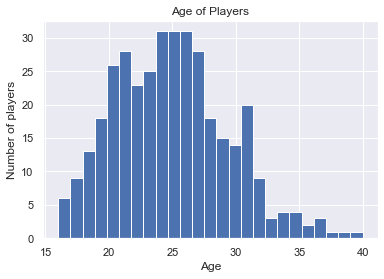

In [16]:
tmk_df["Age"].hist(bins=25)
plt.title('Age of Players')
plt.xlabel('Age')
plt.ylabel('Number of players');

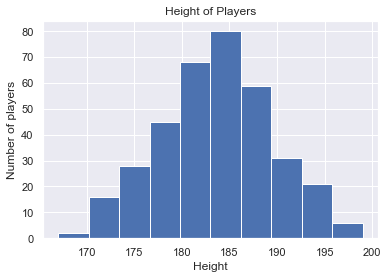

In [17]:
tmk_df["Height"].hist()
plt.title('Height of Players')
plt.xlabel('Height')
plt.ylabel('Number of players');

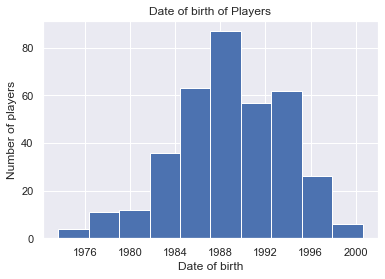

In [18]:
tmk_df["Date of birth"].hist()
plt.title('Date of birth of Players')
plt.xlabel('Date of birth')
plt.ylabel('Number of players');

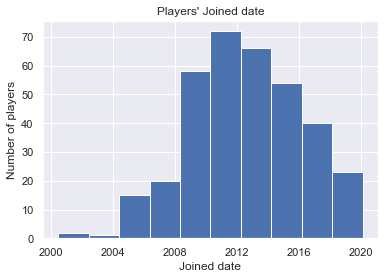

In [19]:
tmk_df["Joined"].hist()
plt.title("Players' Joined date")
plt.xlabel('Joined date')
plt.ylabel('Number of players');

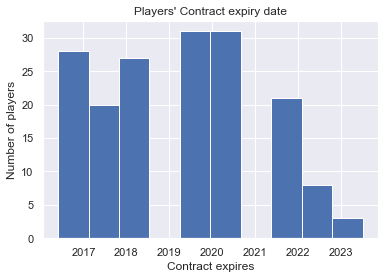

In [20]:
tmk_df["Contract expires"].hist()
plt.title("Players' Contract expiry date")
plt.xlabel('Contract expires')
plt.ylabel('Number of players');

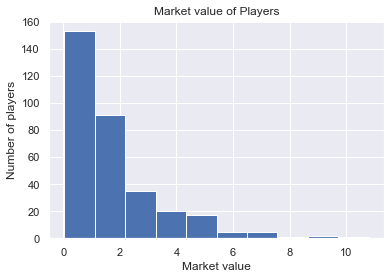

In [21]:
tmk_df["Market value"].hist()
plt.title("Market value of Players")
plt.xlabel('Market value')
plt.ylabel('Number of players');

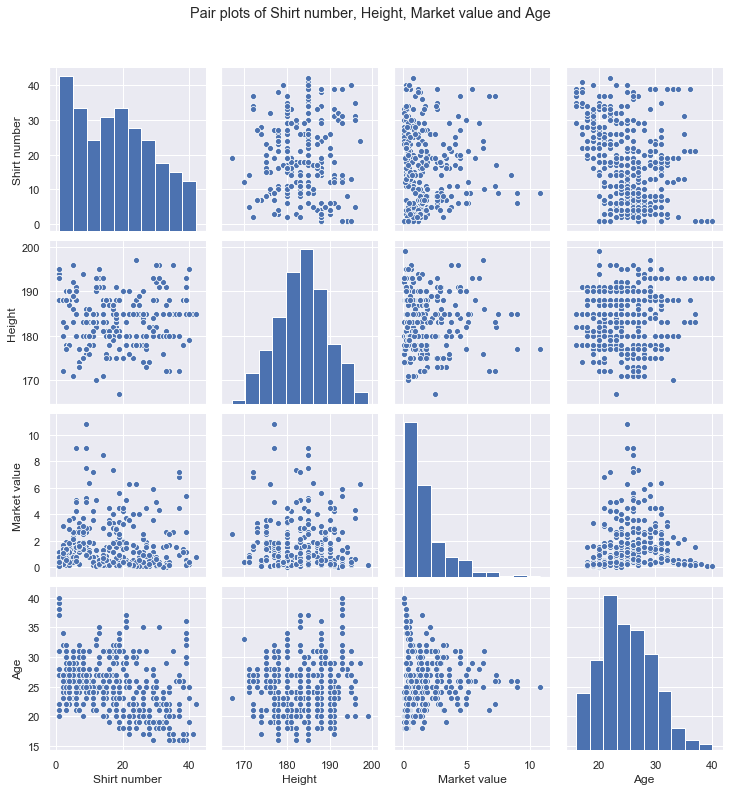

In [22]:
g = sns.pairplot(tmk_df)
g.fig.suptitle("Pair plots of Shirt number, Height, Market value and Age", y=1.08);

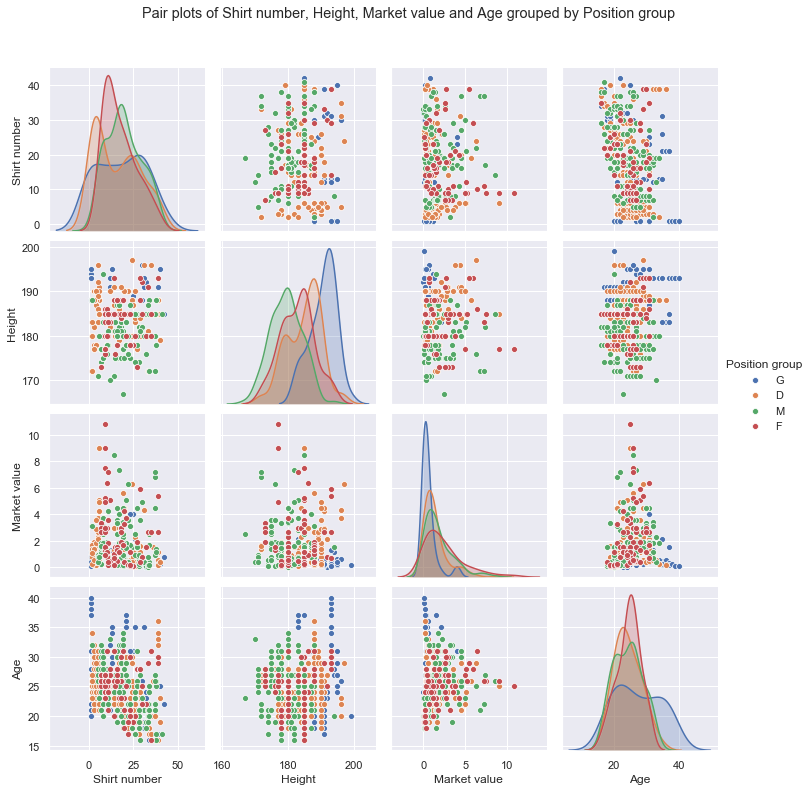

In [23]:
g = sns.pairplot(tmk_df, hue="Position group")
g.fig.suptitle("Pair plots of Shirt number, Height, Market value and Age grouped by Position group", y=1.08);

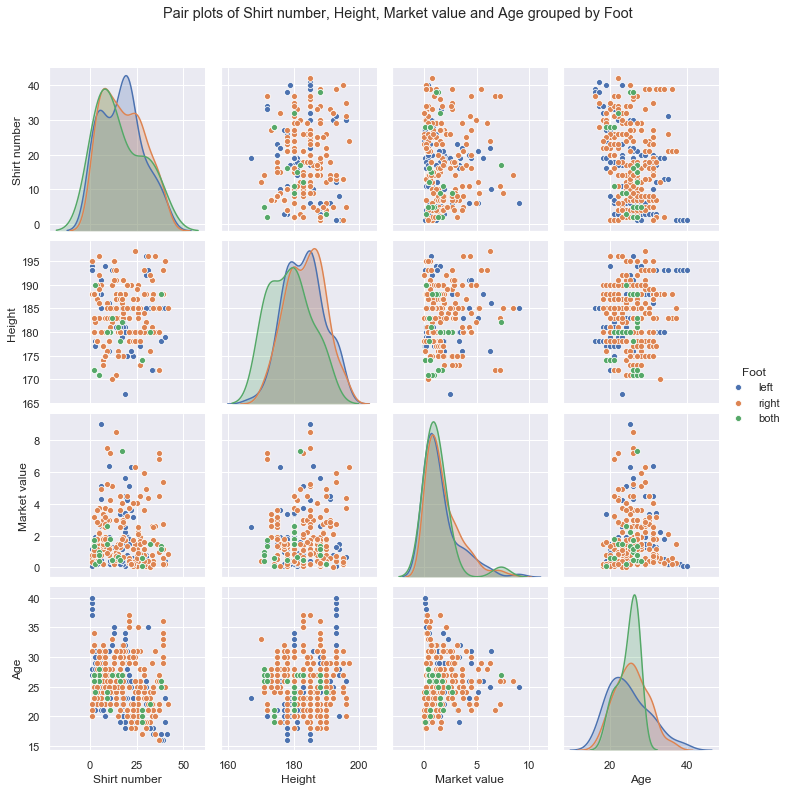

In [24]:
g = sns.pairplot(tmk_df, hue="Foot")
g.fig.suptitle("Pair plots of Shirt number, Height, Market value and Age grouped by Foot", y=1.08);

## 3. Data Preperation

* Select Data
* Clean Data
* Construct Data
* Integrate Data
* Format Data

In [25]:
df = tmk_df.copy()
# df.shape

df["Player key"] = df.Name + " (" + df.Season + ")"
df.set_index(df["Player key"], drop=True, inplace=True, verify_integrity=True)
df.drop(columns=["Player key"], inplace=True)

print("Final dataset created with index from {0} to {1}.".format(df.index[0], df.index[-1]))

Final dataset created with index from Brad Jones (09/10) to Rudy Gestede (19/20).


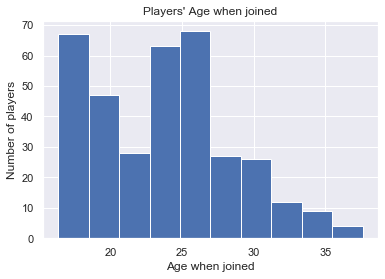

In [26]:
df["Age when joined"] = (df["Joined"] - df["Date of birth"])/ np.timedelta64(1, 'Y')
df["Age when joined"].hist()
plt.title("Players' Age when joined")
plt.xlabel('Age when joined')
plt.ylabel('Number of players');

**ANALYSIS:** Most players join in their teens or mid-twenties.

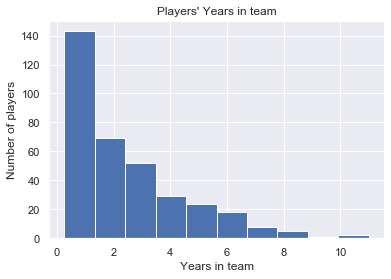

In [27]:
df["Years in team"] = (pd.to_datetime("1st July 20"+df.Season.str[-2:]) - df["Joined"])/ np.timedelta64(1, 'Y')
df["Years in team"].hist()
plt.title("Players' Years in team")
plt.xlabel('Years in team')
plt.ylabel('Number of players');

**ANALYSIS:** I'm going to leave out `Shirt number`, `Position`, `Name`, `Date of birth`, `Joined`, `Season` and `Contract expires` from the model for now. `Contract expires` is populated in less than half of records. The others can be discarded for simplicity of model.

In [28]:
df.drop(columns=["Shirt number", "Position", "Name", "Date of birth", "Joined", "Season", "Contract expires"], inplace=True)
# df.shape

**ANALYSIS:** `Foot` and `Position group` will be one-hot encoded 

In [29]:
for var in ["Foot", "Position group"]:
    df = pd.concat(
        [
            df.drop(var, axis=1),
            pd.get_dummies(
                df[var], prefix=var, prefix_sep="=", drop_first=False
            ),
        ],
        axis=1,
    )

# df.describe()
# df.shape

In [30]:
print("Random sample of records...")

df.sample(5, random_state=RANDOM_STATE)

Random sample of records...


,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M
Player key,,,,,,,,,,,,
Bartholomew Ogbeche (11/12),178.0,0.450,26,26.998501,0.750187,1,0,0,0,1,0,0
Grant Leadbitter (15/16),177.0,1.500,30,26.481037,4.000082,0,0,1,0,0,0,1
Tomás Mejías (17/18),195.0,0.225,29,25.426942,3.989131,0,0,1,0,0,1,0
Andrew Taylor (09/10),178.0,1.880,22,18.916200,4.999418,0,1,0,1,0,0,0
Justin Hoyte (12/13),180.0,1.130,27,23.696585,4.914543,0,0,1,1,0,0,0


In [31]:
print("Summary of whole dataset...")

df.describe()

Summary of whole dataset...


,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M
count,356.000000,330.000000,364.000000,351.000000,351.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,183.286517,1.696327,24.826923,23.871039,2.447119,0.057692,0.280220,0.552198,0.335165,0.178571,0.118132,0.368132
std,6.028752,1.776398,4.696900,4.733915,2.005552,0.233482,0.449725,0.497952,0.472698,0.383520,0.323208,0.482961
min,167.000000,0.038000,16.000000,16.356256,0.265577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,179.000000,0.375000,21.000000,19.409023,0.913092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,183.000000,1.130000,25.000000,23.907404,1.960341,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,188.000000,2.250000,28.000000,26.554960,3.422384,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,199.000000,10.800000,40.000000,37.607891,10.998172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


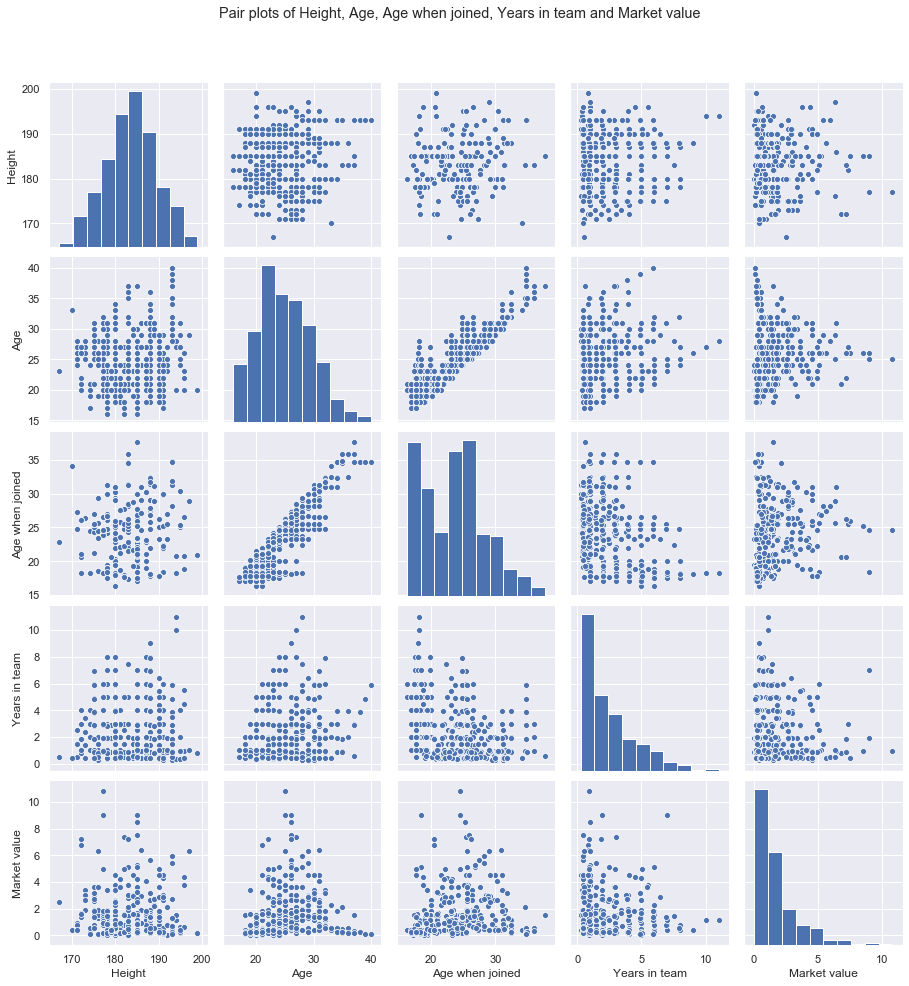

In [32]:
g = sns.pairplot(df[["Height", "Age", "Age when joined", "Years in team", "Market value"]])
g.fig.suptitle("Pair plots of Height, Age, Age when joined, Years in team and Market value", y=1.08);

In [33]:
# df.columns

## 4. Modelling

* Select Modelling Technique
* Generate Test Design
* Build Model
* Assess Model

In [34]:
feature_names = ['Height', 'Age', 'Age when joined', 'Years in team', 'Foot=both',
       'Foot=left', 'Foot=right', 'Position group=D', 'Position group=F',
       'Position group=G', 'Position group=M']

print("\n")
print("Selected features are: {0}".format(feature_names))



Selected features are: ['Height', 'Age', 'Age when joined', 'Years in team', 'Foot=both', 'Foot=left', 'Foot=right', 'Position group=D', 'Position group=F', 'Position group=G', 'Position group=M']


In [35]:
drop_nulls = True

print("\n")
print("Dropping nulls during data preparation: {0}".format(drop_nulls))



Dropping nulls during data preparation: True


In [36]:
if drop_nulls:
    X = df[df.notna().all(axis=1)][feature_names]
    y = df[df.notna().all(axis=1)]["Market value"]
else:
    X = df[feature_names]
    y = df["Market value"]
    
# X.shape, y.shape

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, train_size=0.9)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape
print("\n")
print("Train data has shape: {0}".format(X_train.shape))
print("Test data has shape: {0}".format(X_test.shape))



Train data has shape: (295, 11)
Test data has shape: (33, 11)


In [38]:
number_of_folds = 10
# number_of_folds

In [39]:
kfold = KFold(n_splits=number_of_folds, shuffle=True, random_state=RANDOM_STATE)
# kfold

In [40]:
model = Pipeline([("scaler", MinMaxScaler()),
                  ("estimator", LinearRegression())
                 ])

In [41]:
param_grid = {"estimator__fit_intercept": [True, False],
             "estimator__normalize": [True, False],}
# param_grid

In [42]:
grid = GridSearchCV(model, param_grid, cv=kfold)
# grid

In [43]:
print("\n")
print("Full model grid-space to tune hyperparameters across...")
grid.fit(X_train, y_train)



Full model grid-space to tune hyperparameters across...


GridSearchCV(cv=KFold(n_splits=10, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('estimator',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'estimator__fit_intercept': [True, False],
                         'estimator__normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring

In [44]:
# grid.best_params_

In [45]:
final_model = grid.best_estimator_
# final_model

In [46]:
print("\n")
print("Final tuned model...")
final_model.fit(X_train, y_train)



Final tuned model...


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('estimator',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

## 5. Evaluation

* Evaluate Results
* Review Process
* Determine Next Steps

In [47]:
def model_scores(y_act, y_pred):
    """
    INPUT:
        y_act - Actual values from target vector
        y_pred - Predicted values from target vector
        
    OUTPUT:
        Dictionary containing multiple scoring metrics with nice labels as keys
    """
    
    return {"MedAE": median_absolute_error(y_act, y_pred),
            "RMSE": mean_squared_error(y_act, y_pred, squared=False),
            "R^2": r2_score(y_act, y_pred),
           }

# model_scores?

In [48]:
print("Model scores")

pd.DataFrame(
    [model_scores(y_train, final_model.predict(X_train)), 
    model_scores(y_test, final_model.predict(X_test))], 
    index=["Train", "Test"]
    ).T

Model scores


,Train,Test
MedAE,0.849475,0.994531
RMSE,1.600917,1.376077
R^2,0.223167,0.010775


**ANALYSIS:** The metrics aren't great - even just on the training data - but it's a baseline. The only way is up (I Hope!) :)

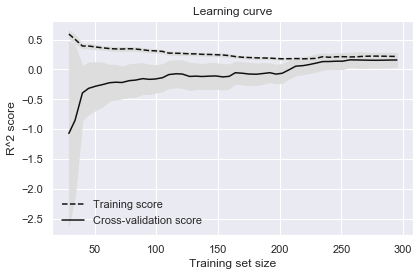

In [49]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(final_model, 
                                                        X, 
                                                        y,
                                                        cv=kfold,
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.1, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning curve")
plt.xlabel("Training set size"), plt.ylabel("R^2 score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

**ANALYSIS:** The model seems pretty weak in general but we can say the learning curves have largely converged so adding extra training samples is unlikely to improve the model.

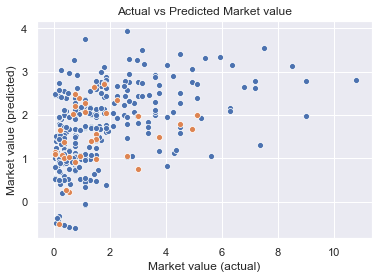

In [50]:
sns.scatterplot(y_train, final_model.predict(X_train))
sns.scatterplot(y_test, final_model.predict(X_test))

plt.title('Actual vs Predicted Market value')
plt.xlabel('Market value (actual)')
plt.ylabel('Market value (predicted)');

**ANALYSIS:** Confirming our scoring visually, it looks pretty weak correlation between actual and predicted values. Note also the model is not able to predict anything much above £4m even though some of the data exceeded £10m.

In [51]:
params = pd.Series(final_model.named_steps["estimator"].coef_, index=X.columns)
# params

np.random.seed(1)
err = np.std([final_model.fit(*resample(X, y)).named_steps["estimator"].coef_ for i in range(1000)], 0)
# err

print("Effect of each feature on the model")
pd.DataFrame({"effect": params.round(2), "error": err.round(2)})

Effect of each feature on the model


,effect,error
Height,0.26,6.200000e-01
Age,24.41,4.440000e+00
Age when joined,-22.72,4.390000e+00
Years in team,-12.20,2.330000e+00
Foot=both,0.01,5.800000e-01
Foot=left,0.36,4.700000e-01
Foot=right,0.42,4.800000e-01
Position group=D,-0.07,7.054699e+13
Position group=F,0.89,7.054699e+13
Position group=G,-1.17,7.054699e+13


**ANALYSIS:** The individual features which appear to have most effect are `Age`, `Age when joined` and `Years in team`. Perhaps the most we can say is old players are cheap.

## 6. Deployment

* Plan Deployment
* Plan Monitoring and Maintenance
* Produce Final Report
* Review Project

In [52]:
df_out = df.copy()
# df_out.shape

In [53]:
if drop_nulls:
    df_out["Market value (prediction)"] = np.NaN
    df_out.loc[df_out.notna()[feature_names].all(axis=1), "Market value (prediction)"] = final_model.predict(df_out[df_out.notna()[feature_names].all(axis=1)][feature_names])
else:
    df_out["Market value (prediction)"] = final_model.predict(df_out[feature_names])

# df_out.shape

In [54]:
print("Summary of whole dataset (with predictions)...")

df_out.describe()

Summary of whole dataset (with predictions)...


,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M,Market value (prediction)
count,356.000000,330.000000,364.000000,351.000000,351.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,347.000000
mean,183.286517,1.696327,24.826923,23.871039,2.447119,0.057692,0.280220,0.552198,0.335165,0.178571,0.118132,0.368132,1.659529
std,6.028752,1.776398,4.696900,4.733915,2.005552,0.233482,0.449725,0.497952,0.472698,0.383520,0.323208,0.482961,0.916826
min,167.000000,0.038000,16.000000,16.356256,0.265577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.344257
25%,179.000000,0.375000,21.000000,19.409023,0.913092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.937653
50%,183.000000,1.130000,25.000000,23.907404,1.960341,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.596059
75%,188.000000,2.250000,28.000000,26.554960,3.422384,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.330483
max,199.000000,10.800000,40.000000,37.607891,10.998172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.218156


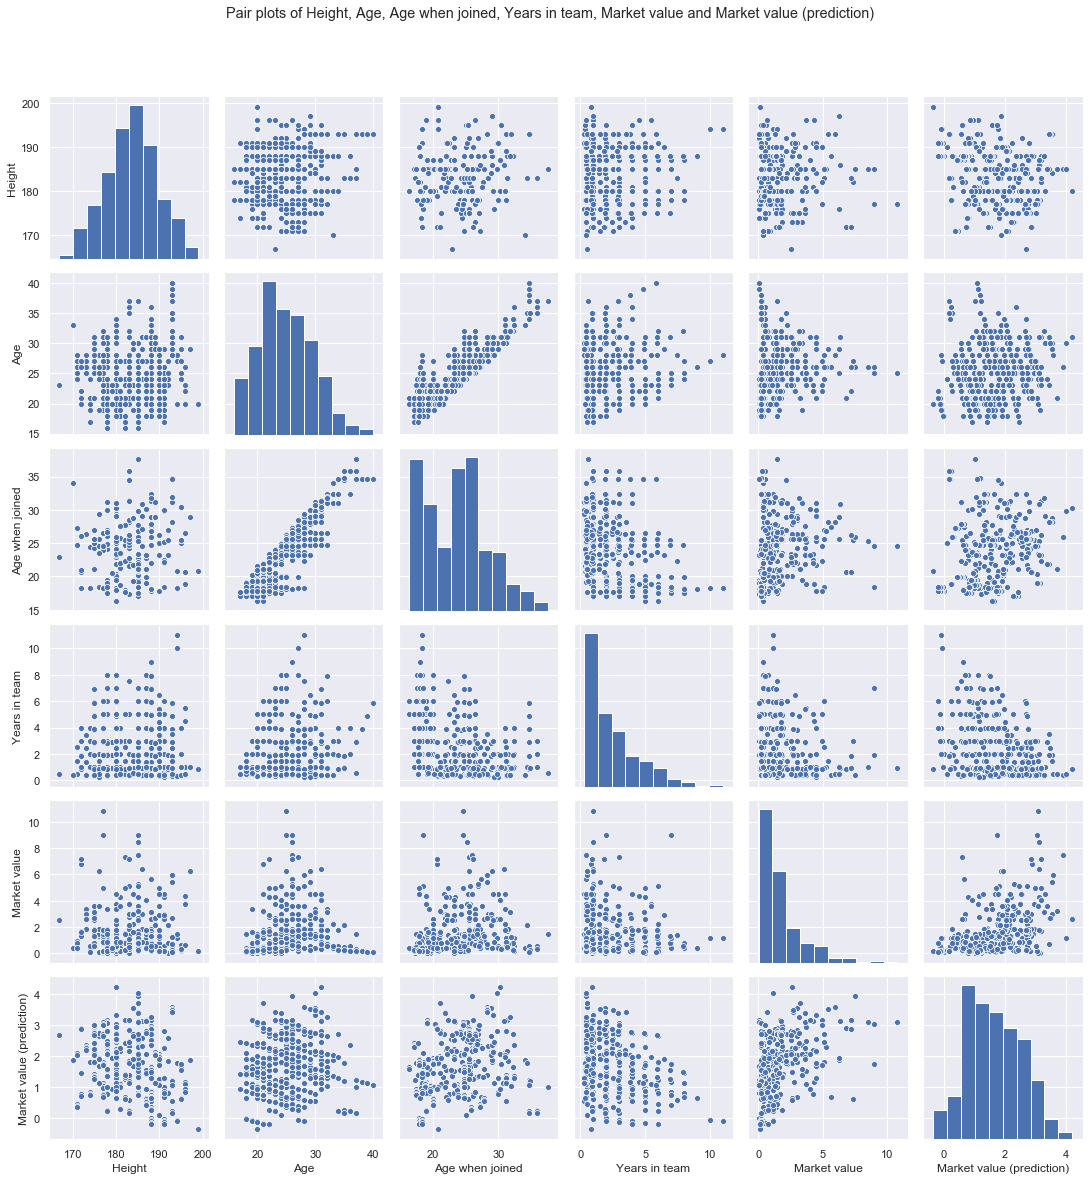

In [55]:
g = sns.pairplot(df_out[["Height", "Age", "Age when joined", "Years in team", "Market value", "Market value (prediction)"]])
g.fig.suptitle("Pair plots of Height, Age, Age when joined, Years in team, Market value and Market value (prediction)", y=1.08);

**ANALYSIS:** As we saw during data preparation there's no clear correlations with continuous features at work. Further our predictions don't even particularly correlate with the actual values.

In [56]:
df_unseen = df_out[df_out["Market value"].isna()]
# df_unseen.shape

In [57]:
print("Summary of unseen records in dataset (no labels)...")

df_unseen[df_unseen["Market value (prediction)"].notna()].describe()

Summary of unseen records in dataset (no labels)...


,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M,Market value (prediction)
count,19.000000,0.0,19.000000,19.000000,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,182.578947,NaN,18.736842,18.809421,1.431925,0.0,0.421053,0.315789,0.315789,0.157895,0.052632,0.473684,1.305653
std,5.766915,NaN,1.284182,1.398387,0.980438,0.0,0.507257,0.477567,0.477567,0.374634,0.229416,0.512989,0.683406
min,172.000000,NaN,17.000000,17.054423,0.334025,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.037862
25%,180.000000,NaN,18.000000,17.831988,0.915830,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.908761
50%,183.000000,NaN,18.000000,18.404211,0.999336,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.325046
75%,185.000000,NaN,20.000000,19.280341,2.000041,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.467859
max,196.000000,NaN,21.000000,21.881353,4.000082,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.049585


In [58]:
print("Predictions below zero")

df_unseen[df_unseen["Market value (prediction)"] < 0.0]

Predictions below zero


,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M,Market value (prediction)
Player key,,,,,,,,,,,,,
Connor Ripley (11/12),191.0,NaN,18,18.376832,1.002074,0,0,0,0,0,1,0,-0.037862


**ANALYSIS:** The player's missing actual Market values are all young players (17-21). The predictions are typically quite small which is as expected at least. Poor Connor Ripley (11/12) gets a negative value!

In [59]:
df_out.to_csv("../data/interim/boro_01_dataset.csv")

In [60]:
clf_file = "../models/boro_01_model.pkl" 
with open(clf_file, "wb") as clf_outfile:
    pickle.dump(final_model, clf_outfile)

In [61]:
ftn_file = "../models/boro_01_feature_names.pkl" 
with open(ftn_file, "wb") as ftn_outfile:
    pickle.dump(feature_names, ftn_outfile)

In [62]:
## save notebook before running `nbconvert`

In [63]:
outFolder = './output'
for filename in os.listdir(outFolder):
    file_path = os.path.join(outFolder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [64]:
!jupyter nbconvert --no-input --output-dir='./output' --to markdown boro_01_current_market_value.ipynb

[NbConvertApp] Converting notebook boro_01_current_market_value.ipynb to markdown
[NbConvertApp] Support files will be in boro_01_current_market_value_files\
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbCon

In [65]:
!jupyter nbconvert --output-dir='./output' --to python boro_01_current_market_value.ipynb

[NbConvertApp] Converting notebook boro_01_current_market_value.ipynb to python
[NbConvertApp] Writing 15543 bytes to ./output\boro_01_current_market_value.py
